# Parallel Jobs

## Example: Airport monitoring

- Get a Sentinel-2 clipped image for 10 airports in a country. 
- Run all jobs in parallel
- Visualize the results

In [1]:
import up42
import pandas as pd
import geopandas as gpd
from pathlib import Path

### Random airports in Spain

Airport locations scrapped from: https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat

In [2]:
country = "Spain"

dat = "https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat"
airports = pd.read_table(dat, 
                         sep=",", 
                         usecols=[0, 1, 3, 6, 7], 
                         names=["uid",'airport', "country", "lat", "lon"])
airports = airports[airports.country==country]
airports = gpd.GeoDataFrame(airports, geometry=gpd.points_from_xy(airports.lon, airports.lat))

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[world.name == country]
airports = airports[airports.within(world.iloc[0].geometry)]

display(airports.head())

,uid,airport,country,lat,lon,geometry
1180,1211,Albacete-Los Llanos Airport,Spain,38.948502,-1.863520,POINT (-1.86352 38.94850)
1181,1212,Alicante International Airport,Spain,38.282200,-0.558156,POINT (-0.55816 38.28220)
1182,1213,Almería International Airport,Spain,36.843899,-2.370100,POINT (-2.37010 36.84390)
1183,1214,Asturias Airport,Spain,43.563599,-6.034620,POINT (-6.03462 43.56360)
1184,1215,Córdoba Airport,Spain,37.841999,-4.848880,POINT (-4.84888 37.84200)


In [3]:
airports=airports.sample(7)

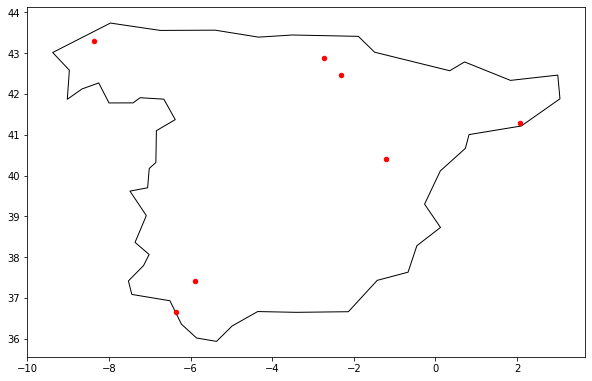

In [4]:
# Visualize locations
ax = world.plot(figsize=(10,10), color='white', edgecolor='black')
airports.plot(markersize=20, ax=ax, color="r")

In [5]:
# Buffer airport point locations by roughly 100m
airports.geometry = airports.geometry.buffer(0.001)

### Prepare UP42 workflows

Create a new project on UP42 or use an existing one.

In [6]:
# Authenticate with UP42
up42.authenticate(project_id="123456", project_api_key="123456", env="dev")
#up42.authenticate(cfg_file="config.json")

project = up42.initialize_project()

2020-08-06 17:06:18,854 - up42.auth - INFO - Authentication with UP42 successful!
2020-08-06 17:06:18,855 - up42 - INFO - Working on Project with project_id ea9bb20e-eb91-4b35-a32e-7e7b81f425c4


In [7]:
# Increase the parallel job limit for the project.
# Only works when you have added your credit card information to the UP42 account.
project.update_project_settings(max_concurrent_jobs=10)

2020-08-06 17:06:20,906 - up42.project - INFO - Updated project settings: [{'name': 'JOB_QUERY_MAX_AOI_SIZE', 'value': '100'}, {'name': 'MAX_CONCURRENT_JOBS', 'value': '10'}, {'name': 'JOB_QUERY_LIMIT_PARAMETER_MAX_VALUE', 'value': '10'}]


In [8]:
workflow = project.create_workflow("workflow_airports", use_existing=True)

2020-08-06 17:06:22,992 - up42.project - INFO - Getting existing workflows in project ...
2020-08-06 17:06:23,267 - up42.project - INFO - Got 2 workflows for project ea9bb20e-eb91-4b35-a32e-7e7b81f425c4.
100%|██████████| 2/2 [00:00<00:00,  3.66it/s]
2020-08-06 17:06:23,826 - up42.project - INFO - Using existing workflow: workflow_airports - ff8ee07a-2bfd-47e3-a410-f640b344ed6b


In [9]:
# Fill the workflow with tasks
blocks = up42.get_blocks(basic=True)

selected_block = "sobloo-s2-l1c-aoiclipped"
workflow.add_workflow_tasks([selected_block])

workflow.get_workflow_tasks(basic=True)

2020-08-06 17:06:26,695 - up42.tools - INFO - Getting blocks name and id, use basic=False for all block details.
2020-08-06 17:06:27,966 - up42.workflow - INFO - Added tasks to workflow: [{'name': 'sobloo-s2-l1c-aoiclipped:1', 'parentName': None, 'blockId': 'a2daaab4-196d-4226-a018-a810444dcad1'}]
2020-08-06 17:06:28,351 - up42.workflow - INFO - Got 1 tasks/blocks in workflow ff8ee07a-2bfd-47e3-a410-f640b344ed6b.


{'sobloo-s2-l1c-aoiclipped:1': '370af804-9589-4596-88b7-6dcd11916a9b'}

### Run jobs in parallel

Queries & downloads one image per airport in parallel.

Crude, this will soon be available in the API in one simple command!

In [10]:
# Run jobs in parallel
up42.settings(log=False)

input_parameters_list = workflow.construct_parameters_parallel(geometries=airports.geometry.to_list(),
                                                               interval_dates=[("2018-01-01","2020-12-31")], 
                                                               geometry_operation="bbox")

for input_param in input_parameters_list:
    input_param[f"{selected_block}:1"]["max_cloud_cover"] = 10

2020-08-06 17:06:30,734 - up42 - INFO - Logging disabled - use up42.settings(log=True) to reactivate.


In [11]:
real_jobs = workflow.run_jobs_parallel(input_parameters_list=input_parameters_list)

In [12]:
real_jobs.download_results()

181it [00:00, 75038.95it/s]
150it [00:00, 78447.08it/s]
131it [00:00, 105664.20it/s]
199it [00:00, 114494.72it/s]
115it [00:00, 90496.24it/s]
155it [00:00, 88127.57it/s]
181it [00:00, 85060.96it/s]


{'f3037da7-ecc4-44c3-ab37-9268d6d49e52': ['/Users/nikoo.ekhtiari/Documents/up42-py/examples/project_ea9bb20e-eb91-4b35-a32e-7e7b81f425c4/job_f3037da7-ecc4-44c3-ab37-9268d6d49e52/6fec06fb-e64a-47d1-942d-9309a514bb3e.tif',
  '/Users/nikoo.ekhtiari/Documents/up42-py/examples/project_ea9bb20e-eb91-4b35-a32e-7e7b81f425c4/job_f3037da7-ecc4-44c3-ab37-9268d6d49e52/data.json'],
 '4f741b88-c196-41c8-822a-ef008125e5f6': ['/Users/nikoo.ekhtiari/Documents/up42-py/examples/project_ea9bb20e-eb91-4b35-a32e-7e7b81f425c4/job_4f741b88-c196-41c8-822a-ef008125e5f6/data.json',
  '/Users/nikoo.ekhtiari/Documents/up42-py/examples/project_ea9bb20e-eb91-4b35-a32e-7e7b81f425c4/job_4f741b88-c196-41c8-822a-ef008125e5f6/42ef407b-a2ed-4b7b-91f3-917b2a89339a.tif'],
 '2ab3d9d6-fe63-4ed7-9277-25775f50bb2d': ['/Users/nikoo.ekhtiari/Documents/up42-py/examples/project_ea9bb20e-eb91-4b35-a32e-7e7b81f425c4/job_2ab3d9d6-fe63-4ed7-9277-25775f50bb2d/data.json',
  '/Users/nikoo.ekhtiari/Documents/up42-py/examples/project_ea9bb2

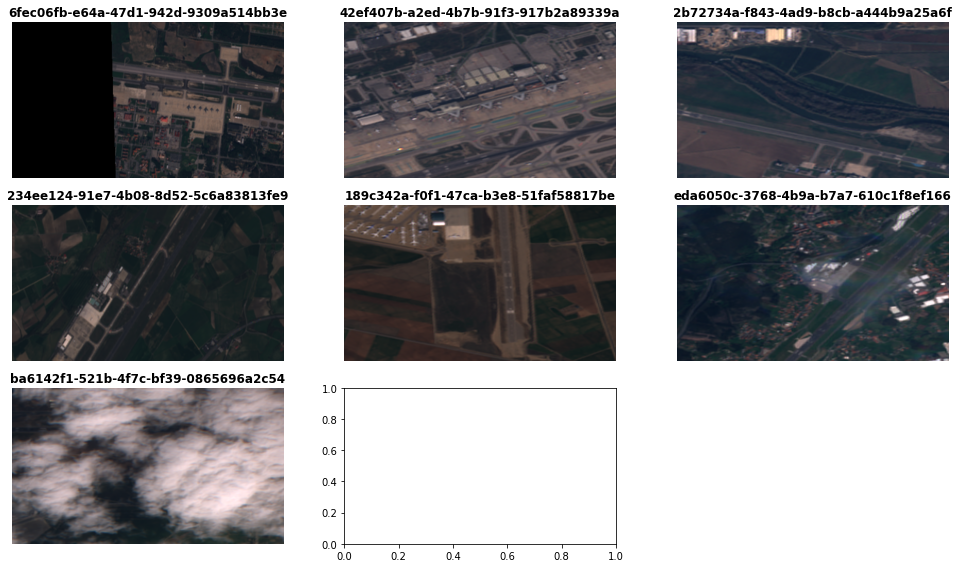

In [13]:
# Visualize downloaded results
real_jobs.plot_results()